# Sensor Modeling

This tutorial demonstrates how to model sensor geometries.

# Setup

In [1]:
import sys

# ! {sys.executable} -m pip install --quiet LibraryCorePy
# ! {sys.executable} -m pip install --quiet LibraryMathematicsPy
# ! {sys.executable} -m pip install --quiet LibraryPhysicsPy
# ! {sys.executable} -m pip install --quiet LibraryAstrodynamicsPy

In [136]:
from IPython.display import Javascript, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio

init_notebook_mode(connected=True)

In [137]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [138]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
LineString2 = Mathematics.Geometry.D2.Objects.LineString
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid
Cone = Mathematics.Geometry.D3.Objects.Cone
Quaternion = Mathematics.Geometry.D3.Transformations.Rotations.Quaternion
RotationVector = Mathematics.Geometry.D3.Transformations.Rotations.RotationVector
RotationMatrix = Mathematics.Geometry.D3.Transformations.Rotations.RotationMatrix

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Velocity = Physics.Coordinate.Velocity
Frame = Physics.Coordinate.Frame
Transform = Physics.Coordinate.Transform
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Celestial = Physics.Environment.Objects.Celestial
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
State = Astrodynamics.Trajectory.State
Access = Astrodynamics.Access

---

## Computation

### Environment

In [139]:
environment = Environment.Default()

In [140]:
earth = environment.accessCelestialObjectWithName("Earth")

In [141]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

In [142]:
first = True
first = False

In [143]:
yaw = Angle.Degrees(180.0)

In [144]:
instant = Instant.DateTime(DateTime(2018, 9, 1, 0, 0, 0), Scale.UTC)

### Satellite

In [145]:
if first:
    
    latitude = Angle.Degrees(0.0)
    longitude = Angle.Degrees(0.0)
    altitude = Length.Kilometers(700.0)
    
else:
    
    latitude = Angle.Degrees(0.0)
    longitude = Angle.Degrees(180)
    altitude = Length.Kilometers(700.0)

In [146]:
lla = LLA(latitude, longitude, altitude)

In [167]:
def body_frame_transform_generator_ITRF (instant):
    
    q_NED_ITRF = Frame.ITRF().getTransformTo(earth.getFrameAt(lla, Celestial.FrameType.NED), instant).getOrientation()
    
    x_B_ITRF = lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening)
    v_B_ITRF = np.array((0.0, 0.0, 0.0))

    q_B_ITRF = q_NED_ITRF
    w_B_ITRF_in_B = np.array((0.0, 0.0, 0.0))
    
    rv_ORB_B = RotationVector.Z(yaw)
    dcm_ORB_B = RotationMatrix.RotationVector(rv_ORB_B)
    q_ORB_B = Quaternion.RotationMatrix(dcm_ORB_B)
    
#     print(q_NED_ITRF.toString())
    
#     print(rv_ORB_B)
#     print(dcm_ORB_B)
#     print(q_ORB_B.toString())
    
    q_B_ORB = q_ORB_B.toConjugate()

    q_B_ITRF = (q_B_ORB * q_NED_ITRF).toNormalized()
    
#     print(q_B_ITRF.toString())
    
    dcm_ITRF_NED = RotationMatrix.Quaternion(q_NED_ITRF.toConjugate())
    dcm_ITRF_B = RotationMatrix.Quaternion(q_B_ITRF.toConjugate())
    
#     print('dcm_ORB_B:', dcm_ORB_B)
#     print('dcm_ITRF_NED:', dcm_ITRF_NED)
#     print('dcm_ITRF_B:', dcm_ITRF_B)
    
    return Transform.Passive(instant, -x_B_ITRF, v_B_ITRF, q_B_ITRF, w_B_ITRF_in_B)

if Frame.Exists("Body"):

    Frame.Destruct("Body")

body_frame = Frame.Construct("Body", False, Frame.ITRF(), Frame.Providers.Dynamic(body_frame_transform_generator_ITRF))

### Sensor

In [168]:
apex_B = Point3(0.0, 0.0, 0.0)
base_B = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_B + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))
# base_B = Polygon3(Polygon2([Point2(0.0, 0.0), Point2(0.0, 0.0), Point2(0.0, 0.0), Point2(0.0, 0.0)]), apex_B + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid_B = Pyramid(base_B, apex_B)

In [169]:
cone_B = Cone(apex_B, np.array((0.0, 0.0, 1.0)), Angle.Degrees(40.0))

In [170]:
# sensor_geometry = Geometry(pyramid_B, body_frame)
sensor_geometry = Geometry(cone_B, body_frame)

### Intersection

In [171]:
def calculate_intersection (instant, sensor_geometry):
    
    sensor_geometry_ITRF = sensor_geometry.inFrame(Frame.ITRF(), instant)
    
#     print(sensor_geometry_ITRF)
    
    intersection_ITRF = sensor_geometry_ITRF.intersectionWith(earth_geometry)
        
#     print(intersection_ITRF)
    
    if not intersection_ITRF.isDefined():
    
        return None
    
    return intersection_ITRF

In [172]:
intersection_ITRF = calculate_intersection(instant, sensor_geometry)

In [173]:
intersection_LLs = [[float(lla.getLongitude().inDegrees()), float(lla.getLatitude().inDegrees())] for lla in [LLA.Cartesian(point_ITRF.asVector(), Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.accessComposite().accessObjectAt(0).asLineString()]]

In [174]:
# intersection_LLs

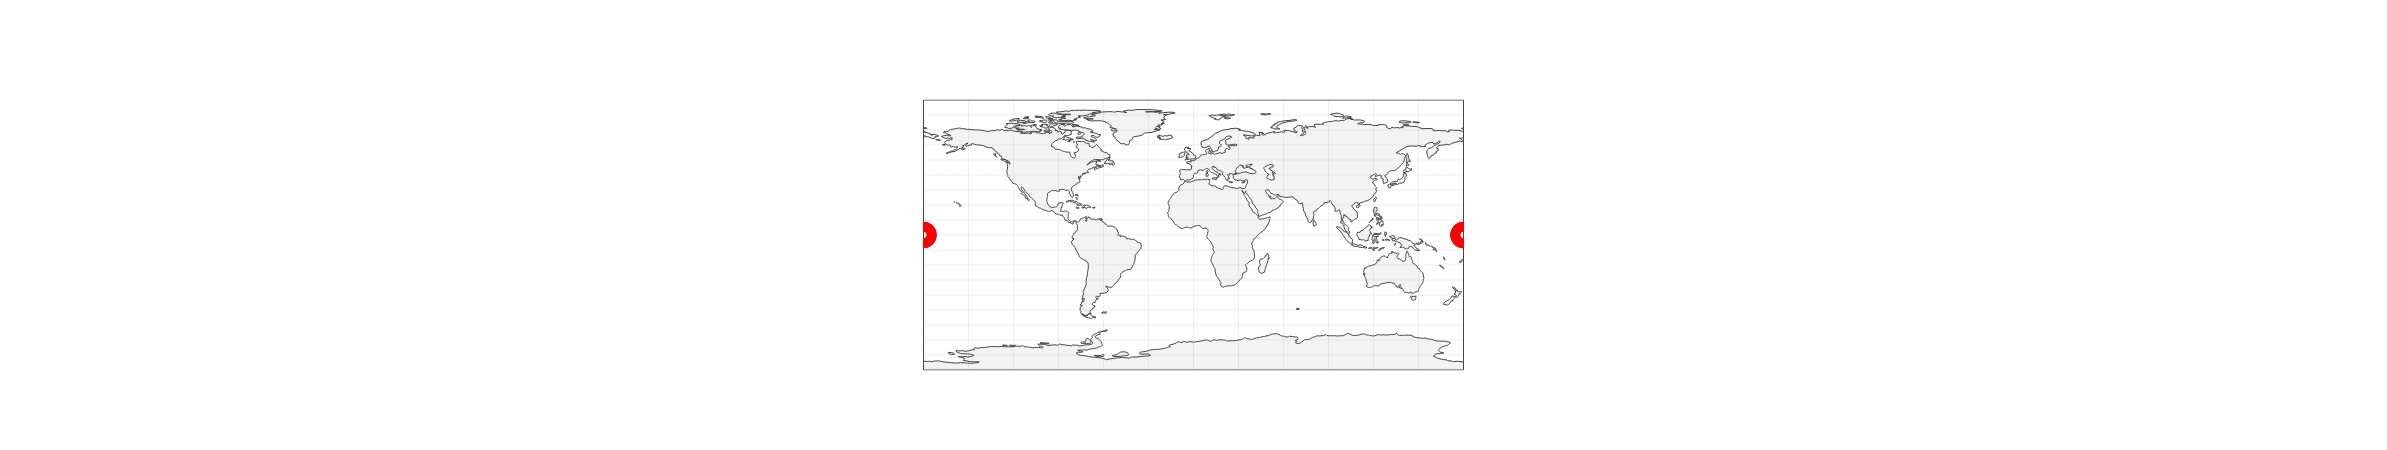

In [175]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = [*[intersection_LL[0] for intersection_LL in intersection_LLs], intersection_LLs[0][0]],
        lat = [*[intersection_LL[1] for intersection_LL in intersection_LLs], intersection_LLs[0][1]],
        mode = 'markers',
        marker=dict(
            size=10,
            color = 'red'
        ),
        line = dict(
            width = 1,
            color = 'rgba(0, 0, 255, 0.5)',
        )
    )
)
    
layout = dict(
        title = None,
        showlegend = False,
#         width=1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.1
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.1
            )
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)